# Beam Shape Analysis - Cleaved Fibre

### What does this notebook do?

Experimental analysis
- Import Gaussian beamshape data and z values through pandas to np arrays
- Translate and transform Gaussians to reduce fitting parameters 
- Fit the beamshape Gaussians to a one parameter fit to find their waists, w
- multiply z by sin(theta), where theta is the elevation angle of the setup - so that we resolve the projection onto the camera image
- Plot ws vs zsin(theta) and fit to (Two/ three parameter?) Fit
- Key: what is z0 and w0 experimentally for the fibre?

Theoretical Analysis
- Takes in wavelength, NA, core radius to calculate V number
- Use marcuse relation to find minumum waist
- Comparison?

In [23]:
''' IMPORTANT: compared to annotated picture, 11th data point was deleted due to corrupted file. File was called '1007'. Therefore now working with 16 data points'''

" IMPORTANT: compared to annotated picture, 11th data point was deleted due to corrupted file. File was called '1007'. Therefore now working with 16 data points"

## Import all useful libraries / tools

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from os import listdir
import scipy

## Import Data

Function below that takes path and returns distances and amplitudes from all csv files in that folder, as np.ndarrays in a big list

In [25]:
def import_data(global_path):

    # Function which finds filenames of csvs in a folder
    def find_csv_filenames( path_to_dir, suffix=".csv" ):
        filenames = listdir(path_to_dir)
        return [ filename for filename in filenames if filename.endswith( suffix ) ]
    
    def sort_int(examp):
        pos = 1
        while examp[:pos].isdigit():
            pos += 1
        return examp[:pos-1] if pos > 1 else examp

    # the list of files in the folder
    files_list = find_csv_filenames(global_path)
    
    sorted(files_list, key=sort_int) # sort files

    files_list = files_list[:-1] # -1 to not include 'zs' csv file - import this later

    # empty lists to put values in
    distances = []
    amps = []

    print(files_list)

    # loop through file names in directory
    for f in range(len(files_list)):

        # Import an execl sheet as dataframe, called 'Values1'
        # NB: Image J seems to have saved this 'excel sheet' as a csv file
        df_test = pd.read_csv(global_path + files_list[f])

        # Extracing a column by title and converting data to array
        distances.append(np.array(df_test['Distance_(microns)']))
        amps.append(np.array(df_test['Gray_Value']))

    # returning arrays within two big lists
    return distances, amps

In [26]:
# Define useful path to data
globalpath = "C:/Users/abiga/OneDrive - Durham University/1. Fourth Year/1. Project/1. Data Analysis/Christmas Report/Cleaved-2/Data2/"

In [27]:
distances, amplitudes = import_data(globalpath)

['1001.csv', '10011.csv', '1002.csv', '10021.csv', '1003.csv', '10031.csv', '1004.csv', '10041.csv', '1005.csv', '1006.csv', '1008.csv', '1009.csv', '10091.csv', '10092.csv', '10093.csv', '10094.csv']


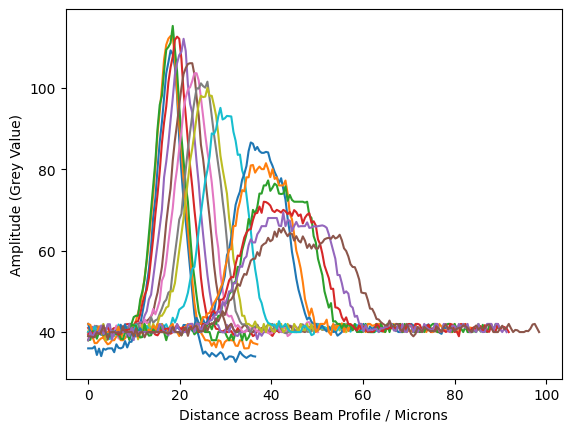

In [28]:
for i in range(len(distances)):
    plt.plot(distances[i], amplitudes[i])

plt.xlabel('Distance across Beam Profile / Microns')
plt.ylabel('Amplitude (Grey Value)')

plt.show()

## Normalise, cut down data

In [29]:
def data_trim(distances_, amplitudes_, cutoff):

    '''A function to tidy up the raw gaussian data. Implements measures to normalise and trasform data such that
    the only fitting parameter becomes the waist of the beam, W. '''

    new_distances = []
    new_amps = [] # some empty lists to append to at the end of the loop

    for j in range(len(distances_)): # iterate through distances (amps)

        # Get rid of vertical offset - to reduce a fitting parameter
        subt_amp = amplitudes_[j] - np.min(amplitudes_[j])

        # Normalise data by its maximum value
        norm_amp = subt_amp / np.max(subt_amp)

        dist_max = 0 # to add to later

        # # Move data so centred on zero - reduce fitting params further
        # for i in range(norm_amp.size):
        #     if norm_amp[i] == np.max(norm_amp):
        #         dist_max = distances_[j][i]

        # shifted_distances = distances_[j] - dist_max

        shifted_distances = distances_[j]

        cut_dist = 0
        cut_amps = 0

        if len(shifted_distances) > cutoff:
            cut_dist = shifted_distances[0:cutoff]
            cut_amps = norm_amp[0:cutoff]

            # Add adjusted data set to the new large lists
            new_distances.append(cut_dist)
            new_amps.append(cut_amps)

        else:
            new_distances.append(shifted_distances)
            new_amps.append(norm_amp)

    return new_distances, new_amps

In [30]:
all_distances, all_amps = data_trim(distances, amplitudes, 10000000)

## Errors - for above normalised Gaussians

In [31]:
''' Error on cross sectional distance'''
# Scale says ~2 pixels / microns therefore 0.5 microns / pixel
# so lets set error as 0.5 microns

all_distances_errors = []

for i in range(len(all_distances)):
    all_distances_errors.append(np.ones(np.size(all_distances[i]))*0.5) # takes into account different sized data sets

''' Error on amplitude '''
# Grey value resolution = 1

all_amps_errors = []

for i in range(len(all_amps)):
    err = 1 / np.max(amplitudes[i])
    all_amps_errors.append(np.ones(np.size(all_amps[i]))*err) # takes into account different sized data sets

Plot Normalised Gaussian Curves with Errors

Text(0, 0.5, 'Normalised Amplitude')

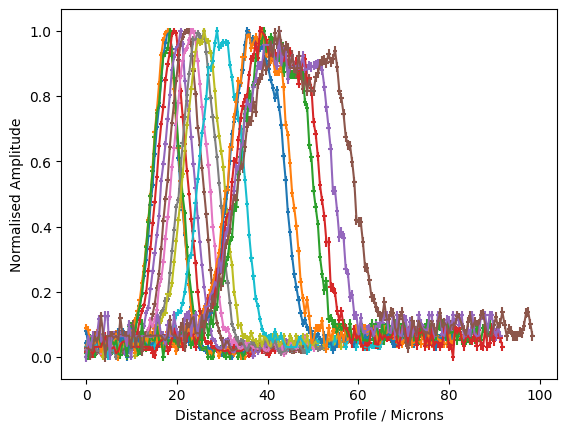

In [32]:
for i in range(len(all_distances)):
    plt.errorbar(all_distances[i], all_amps[i], xerr=all_distances_errors[i],yerr=all_amps_errors[i])

plt.xlabel('Distance across Beam Profile / Microns')
plt.ylabel('Normalised Amplitude')

## Fit Data

Defining useful functions - using chi squared and fit_labs, previously written

In [33]:
def chi_squared(model_params, model, x_data, y_data, y_error):
    return np.sum(((y_data - model(x_data, *model_params))/y_error)**2)

In [34]:
def fit_labs(xdata,ydata, yerrors, function, initial_guess):

    dof = np.size(xdata) - np.size(initial_guess) ## degrees of freedom

    if np.size(yerrors) == 1:

        yerr_extended = np.zeros(np.size(xdata))
        for i in range(np.size(yerr_extended)):
            yerr_extended[i] = yerrors

        parameters, covariance = curve_fit(function, xdata, ydata, sigma = yerr_extended, absolute_sigma = True, p0 = initial_guess, maxfev = 50000)

    else:
    
        parameters, covariance = curve_fit(function, xdata, ydata, sigma = yerrors, absolute_sigma = True, p0 = initial_guess, maxfev = 50000)

    perrors = np.sqrt(np.diag(covariance))

    chisq_min = chi_squared(parameters,
                        function, 
                        xdata, 
                        ydata, 
                        yerrors) 
    
    chisq_reduced = chisq_min / dof

    # p_value = scipy.stats.chi2.sf(chisq_min, dof)

    yfit = function(xdata, *parameters)

    return yfit, parameters, perrors, chisq_min

In [35]:
def Gauss(x, W, C): ### Defien Gaussian with TWO parameters
    y = np.exp((-2*((x-C)**2) / W**2))
    return y

Text(0.5, 1.0, 'Waist Size Trend - Errorbars too small to see')

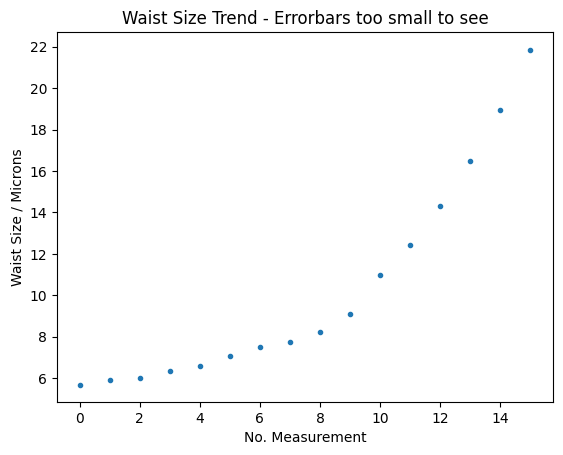

In [36]:
# Create some empty arrays to store values of interest
params_ = np.zeros((len(all_distances),2))
y_fits = [] # NB: this has to be a list due to different sized arrays sitting in it
params_errs_ = np.zeros((len(all_distances),2))
chi_min_array = np.zeros(len(all_distances))

# Populate initial guess array - important to change per data set!!
initial_guesses = np.zeros((len(all_distances),2))
initial_guesses[:,1] = 20
initial_guesses[:,0] = 3
initial_guesses[0,0] = 15
initial_guesses[1,0] = 15
initial_guesses[9:,0] = 40
initial_guesses[9:,1] = 50

for i in range(len(all_distances)):
    singlefit, params_[i], params_errs_[i], chi_min_array[i] = fit_labs(all_distances[i],all_amps[i], all_amps_errors[i], Gauss, initial_guesses[i])
    y_fits.append(singlefit)

waists = params_[:,0]
waists_errs = params_errs_[:,0]

# Plot waist trend 
plt.errorbar(np.arange(len(distances)),waists, yerr = waists_errs, linestyle = '', marker = 'o', ms = 3)
plt.xlabel('No. Measurement')
plt.ylabel('Waist Size / Microns')
plt.title('Waist Size Trend - Errorbars too small to see')

#print(waists, waists_errs)

## Calculating Z values and Plotting Waist size against Z

In [37]:
# Define Global Path for where 'z' values are stored
z_path = 'C:/Users/abiga/OneDrive - Durham University/1. Fourth Year/1. Project/1. Data Analysis/Christmas Report/Cleaved-2/Data2/zs.csv'

# Import as dataframe
df_lengths = pd.read_csv(z_path)

# Convert to array. Called 'lengths' as this isnt the z values yet
lengths = np.array(df_lengths['Length'])

# Take error as pixel width ie 0.5 microns (1sf)
lengths_errs = np.ones(len(lengths))*0.5

In [38]:
print(lengths)

[  0.      2.613   5.21    7.822  10.434  13.257  16.331  19.187  21.787
  28.17   40.04   48.285  60.869  75.791  88.812 107.279]


This 'lengths' value MIGHT need to be multiplied by cos theta? Where theta is angle of elevation of the fibre... but won't do this yet.

## Fit Waists vs Z

In [39]:
# Need wavelength of light to calc. Rayleigh Range (in microns)
wavelength = 0.405
wavelength_err = 0.005 # according to online spec (THORLABS CPS405)

In [73]:
# Define w vs z theoretical relation

def WvsZ(x, min_w,C):
    # define rayleigh range
    RR = (np.pi * min_w**2) / wavelength
    return min_w * np.sqrt(1 + ((x-C)/RR)**2)

Angle of elevation

In [41]:
# online protractor at https://www.ginifab.com/feeds/angle_measurement/ 
# NB: see image 'C:\Users\abiga\OneDrive - Durham University\1. Fourth Year\1. Project\1. Data Analysis\Christmas Report\Cleaved-2\Cleaved - fibre- pics\cleaved_elev_angle'


[0.02341542 0.0236191  0.02351468 0.02480377 0.02562479 0.02773709
 0.02936106 0.03041504 0.03198313 0.03546101 0.04277512 0.04825879
 0.05508627 0.06347439 0.07174694 0.08197175]


<ErrorbarContainer object of 3 artists>

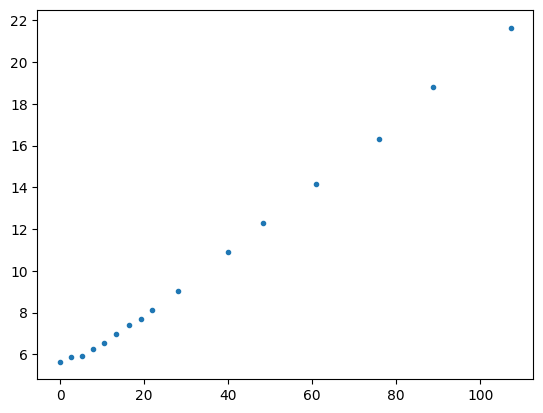

In [59]:
angle_deg = 8
angle_deg_err = 1
angle = angle_deg * np.pi / 180
angle_err = angle_deg_err * np.pi / 180

# Multiply waists by COS of angle to obtain correct component distance
# Leave zs for now?
zs = lengths
waists_comp = waists*np.cos(angle)


sin_err = np.abs(np.sin(angle + angle_err) - np.sin(angle))
cos_err = np.abs(np.cos(angle + angle_err) - np.cos(angle))
waists_comp_err = waists_comp*np.sqrt( (cos_err / np.cos(angle))**2 + (waists_errs/waists)**2 )
print(waists_comp_err)

plt.errorbar(zs, waists_comp, yerr = waists_comp_err, linestyle = '', marker = 'o', ms = 3)


In [76]:
waist_fit, params, params_errs, chisqu_WvsZ = fit_labs(zs, waists_comp, waists_comp_err, WvsZ, np.array([100,0]))
w0, z0= params
w0_err, z0_err = params_errs

The minimum waist is 0.8801357650412511 pm 0.0024596088980423886
The distance from the first measurement to the minimum waist is -34.970173100576524 pm 0.15184641286154293


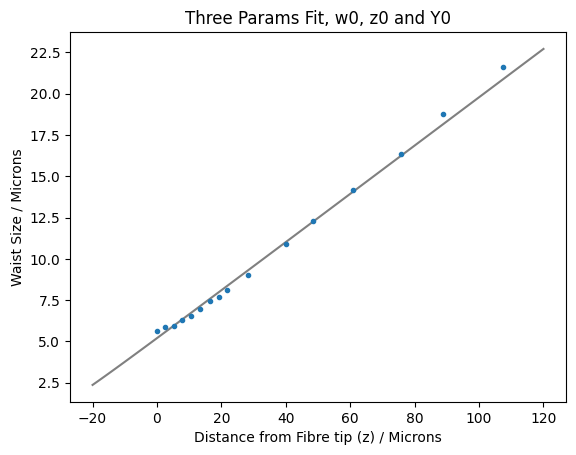

In [77]:
# Plot waists vs Z:
plt.errorbar(zs, waists_comp, yerr = waists_comp_err, linestyle = '', marker = 'o', ms = 3)
plt.plot(np.linspace(-20,120,100), WvsZ(np.linspace(-20,120,100), w0, z0), color = 'grey')
plt.xlabel('Distance from Fibre tip (z) / Microns')
plt.ylabel('Waist Size / Microns')
plt.title('Two Params Fit, w0, z0')

#plt.plot(np.linspace(-100,450,100), WvsZ(np.linspace(-100,450,100), 3, z0), color = 'green')
#plt.scatter(lengths*np.cos(np.pi / 12),waists*np.cos(np.pi / 12), color = 'darkgreen')

print('The minimum waist is {} pm {}'.format(w0, w0_err))
print('The distance from the first measurement to the minimum waist is {} pm {}'.format(z0, z0_err))
#print('The weird systematic error Y is {} pm {}'.format(Y0, Y0_err))

## Comparison to Experiment - Ray Optics Model

In [61]:
# Defining Parameters of set-up
# info about fibre from 35m cable:
''' https://www.thorlabs.com/drawings/b4627de8c1f781cd-1251149A-D70E-815D-5BD8491D7FDA5B7B/PM1550-HP-SpecSheet.pdf '''

NA = 0.14 # numerical aperture 
NA_err = 0.01

def find_k(wl): # in microns
    return 2*np.pi / (wl*10**(-6)) # wavenumber, SI units

k0 = find_k(wavelength)
k0_err = np.abs(find_k(wavelength+wavelength_err) - k0)
print(k0, k0_err)

a = 9.2e-6 / 2 # core radius, in metres 
a_err = 0.1e-6 / 2 

15514037.795505151 189195.5828720145


In [62]:
V_no = NA * k0 * a

EC_NA = np.abs(((NA+NA_err) * k0 * a) - V_no)
EC_k0 = np.abs((NA * (k0+k0_err) * a) - V_no)
EC_a = np.abs((NA * k0 * (a+a_err) - V_no))

V_no_err = np.sqrt(EC_NA**2 + EC_k0**2 + EC_a**2)

In [63]:
print('The predicted V no is {} pm {}'.format(V_no, V_no_err))

The predicted V no is 9.99104034030532 pm 0.7320719127024782


Defining the Marcuse Relation below, to compute theoretical minimum waist from V number and core radius

In [64]:
def marcuse(V,A):
    return A*( 0.65 + 1.619*V**(-3/2) + 2.879*V**(-6) )*10**6

In [67]:
w0_theory = marcuse(V_no,a)

# error on w0
cont_V_no = np.abs(marcuse(V_no+V_no_err,a) - w0_theory)
cont_a = np.abs(marcuse(V_no,a+a_err) - w0_theory)

w0_theory_err = np.sqrt(cont_V_no**2 + cont_a**2)

0.023737367481655447 0.03506345267546651


In [66]:
print('The predicted minimum waist using the ray optics model is {} pm {} microns'.format(w0_theory,w0_theory_err))

The predicted minimum waist using the ray optics model is 3.2258376461429026 pm 0.042342748239619886 microns
